In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import glob as gl
import os
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC 

In [ ]:
#https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

In [2]:
path = "src/results"

""" datetime = "/2011-03-24_15"
df = pd.read_csv(path + datetime + '.csv')  """


dfs = []

for file in gl.glob(path + '/20*.csv'):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
#df.count() #cada csv tiene 160920 filas

## Label Encoder

In [3]:
modelo = df.iloc[:, 8].values 
modelo = LabelEncoder().fit_transform(modelo) #codificación del modelo

In [4]:
df = df.drop(df.columns[8], axis=1) #se elimina la antigua con los strings del modelo
df['modelo'] = modelo #se añade la nueva codificada al final

X = df.iloc[:, 1:] 
X = X.drop(['datetime', 'timestamp', 'load', 'DC Array Output (W)' , 'Pavg', 'dif'], axis=1)
y = df.iloc[:, 0].values #valores de overflow

X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux', 'h',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

## Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = StandardScaler() #escalado de datos
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## PCA

In [7]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## SVM

In [8]:
inicl = time.time()
classifier = SVC(kernel = 'rbf', random_state = 0) #ESTO HA TARDADO LA VIDA Y MEDIA.... 487min, con PCA tarda 69 min

#classifier.fit(X_train, y_train)
classifier.fit(X_train_pca, y_train)
classifier.estimators_

fincl = time.time()
print(fincl-inicl) 

SVC(random_state=0)

## Evaluación

### Matriz de confusión

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
#y_pred = classifier.predict(X_test)
y_pred = classifier.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
print(cm) 
accuracy_score(y_test, y_pred)

#0.9780040807026266 || [[377074     70] [  8425    639]] sin PCA
#0.9765307813406248 || [[377144      0] [  9064      0]] con PCA (2)
# ||  con PCA (3)

KeyboardInterrupt: 

### K-Fold

In [13]:
#accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies = cross_val_score(estimator = classifier, X = X_train_pca, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

## Figuras (mal)

C:\Users\Paula\AppData\Local\Temp\ipykernel_18132\165783590.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


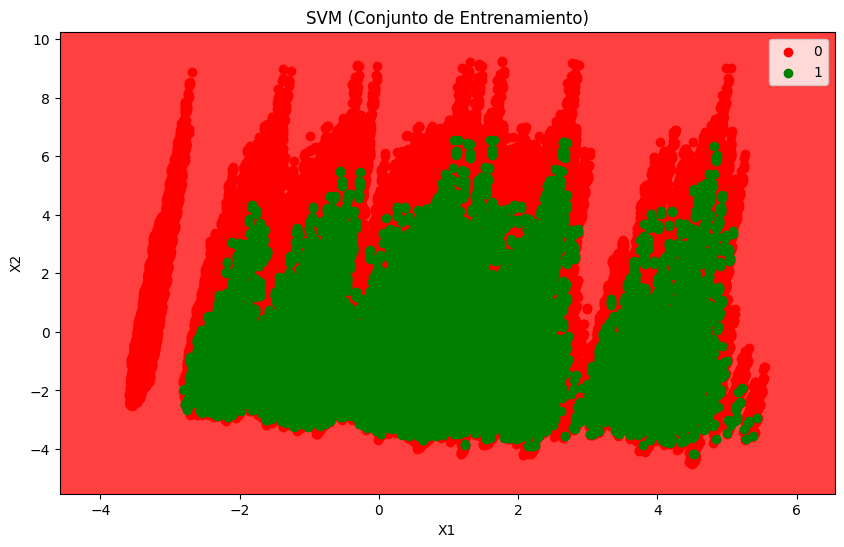

In [9]:
plt.figure(figsize=(10, 6))

X_set, y_set = X_train_pca, y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap=ListedColormap(('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('SVM (Conjunto de Entrenamiento)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

## Grid Search

### Estimación de tiempos

In [ ]:
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf']}]

processors = 32
cv = 5 
combos = 1

for j in parameters.values():
    combos *= len(j)

num_models = combos * cv / processors 
seconds = num_models * (fincl-inicl)
minutes = seconds / 60
hours = minutes / 60

print("{:.6f}".format(hours), "| {:.6f}".format(minutes), "| {:.6f}".format(seconds)) 

In [ ]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

print(grid_search.best_estimator_)

NameError: name 'classifier' is not defined